## Explanation of the GDA Model
Gaussian Discriminant Analysis is a generative learning algorithm based on Bayes' Theorem. Unlike discriminative models (like Logistic Regression) which learn a decision boundary directly, GDA tries to model the distribution of the data for each class.

### Core Idea:

1.  **Distribution Assumption:** GDA assumes that the features $x$, given a class $y=k$, follow a **multivariate Gaussian distribution**, denoted as $p(x|y=k) \sim \mathcal{N}(\mu_k, \Sigma_k)$.
    *   $\mu_k$ is the mean vector of the features for class $k$.
    *   $\Sigma_k$ is the covariance matrix of the features for class $k$.

2.  **Learning Parameters:** During training, the algorithm learns the following parameters from the training data for each class:
    *   **Prior Probability** $\phi_k = p(y=k)$: The overall probability of class $k$ appearing in the data.
    *   **Mean Vector** $\mu_k$.
    *   **Covariance Matrix** $\Sigma_k$.

3.  **Making Predictions:** For a new data point $x$, the model uses Bayes' Theorem to calculate the **posterior probability** that it belongs to each class $k$:
    $$ p(y=k|x) = \frac{p(x|y=k)p(y=k)}{p(x)} $$
    Since the denominator $p(x)$ is the same for all classes, we only need to find the class $k$ that maximizes the numerator, $p(x|y=k)p(y=k)$. The model predicts the class that yields the highest posterior probability.

## Why is GDA suitable for this dataset?
In our dataset, the "valid" points (Label=1) form a cluster that geographically represents the island of Taiwan, while the "invalid" points (Label=0) are scattered in the surrounding sea. It's reasonable to assume that these two groups of points form distinct groups in the 2D space of (longitude, latitude). In this case, we use QDA, since the shape of the island (a narrow ellipse) is clearly different from the shape of the surrounding sea area.

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False

def load_and_parse_data(xml_file):
    start_lon, start_lat = 120.00, 21.88
    lon_resolution, lat_resolution = 0.03, 0.03
    lon_count, lat_count = 67, 120
    invalid_value = -999.0

    tree = ET.parse(xml_file)
    root = tree.getroot()
    namespace = {'cwa': 'urn:cwa:gov:tw:cwacommon:0.1'}
    content_str = root.find('.//cwa:Content', namespace).text
    
    raw_values = []
    lines = content_str.strip().split('\n')
    for line in lines:
        values = [float(v) for v in line.strip().split(',') if v.strip()]
        raw_values.extend(values)

    lons = np.arange(lon_count) * lon_resolution + start_lon
    lats = np.arange(lat_count) * lat_resolution + start_lat
    grid_points = []
    for lat in lats:
        for lon in lons:
            grid_points.append((lon, lat))
            
    num_expected_points = lon_count * lat_count
    if len(raw_values) != num_expected_points:
        raw_values = (raw_values + [invalid_value] * num_expected_points)[:num_expected_points]

    df = pd.DataFrame(grid_points, columns=['longitude', 'latitude'])
    df['temperature'] = raw_values
    return df

def create_classification_dataset(base_df):
    df_cls = base_df.copy()
    df_cls['label'] = (df_cls['temperature'] != -999.0).astype(int)
    X = df_cls[['longitude', 'latitude']].values
    y = df_cls['label'].values
    return X, y

(a) GDA

In [ ]:
class QDA:
    """
    Quadratic Discriminant Analysis
    """
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.priors = {}
        self.means = {}
        self.covs = {}

        for c in self.classes:
            X_c = X[y == c]
            
            #  Prior Probability: phi_c = p(y=c)
            self.priors[c] = X_c.shape[0] / n_samples
            
            #  Mean Vector mu_c
            self.means[c] = np.mean(X_c, axis=0)
            
            #  Covariance Matrix Sigma_c 
            self.covs[c] = np.cov(X_c, rowvar=False, bias=True)
            
    def predict(self, X):
        n_samples, n_features = X.shape
        posteriors = []

        # Posterior Probability
        for c in self.classes:
            prior = self.priors[c]
            mean = self.means[c]
            cov = self.covs[c]
            
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)
            
            # PDF of multi-var Gaussian distribution.
            # log(p(x|y)) = -0.5 * log(det(Sigma)) - 0.5 * (x-mu)^T * Sigma^-1 * (x-mu) - C
            log_likelihoods = np.zeros(n_samples)
            for i, x_i in enumerate(X):
                diff = (x_i - mean).reshape(-1, 1)
                exponent = -0.5 * diff.T @ inv_cov @ diff
                log_likelihoods[i] = exponent
            
            # log(p(y|x)) is proportional to log(p(x|y)) + log(p(y))
            posterior = np.log(prior) - 0.5 * np.log(det_cov) + log_likelihoods.flatten()
            posteriors.append(posterior)
        
        posteriors = np.array(posteriors)
        return self.classes[np.argmax(posteriors, axis=0)]

C:\Users\USER\AppData\Local\Temp\ipykernel_121272\3550087576.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihoods[i] = exponent
C:\Users\USER\AppData\Local\Temp\ipykernel_121272\3550087576.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihoods[i] = exponent


Accuracy: 0.8333

report:
              precision    recall  f1-score   support

     Label 0       0.84      0.87      0.85      1363
     Label 1       0.82      0.79      0.81      1049

    accuracy                           0.83      2412
   macro avg       0.83      0.83      0.83      2412
weighted avg       0.83      0.83      0.83      2412



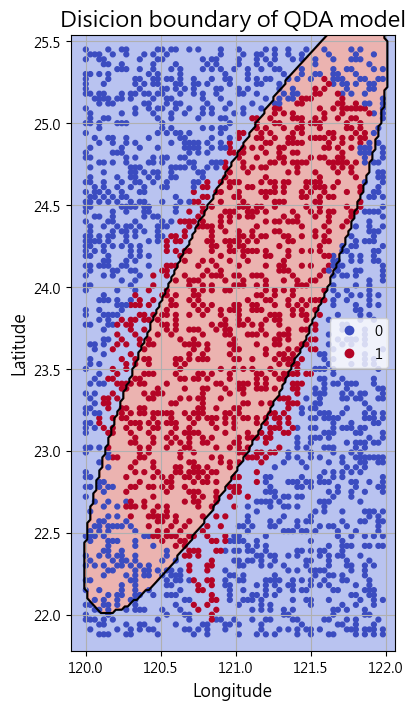

In [ ]:
xml_filename = "O-A0038-003.xml"
base_df = load_and_parse_data(xml_filename)
X, y = create_classification_dataset(base_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

qda_model = QDA()
qda_model.fit(X_train, y_train)
y_pred = qda_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Label 0', 'Label 1'])

print(f"Accuracy: {accuracy:.4f}")
print("\nreport:")
print(report)

# --- Drawing boundary ---

x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = qda_model.predict(grid_points)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z, colors='k', linewidths=1.5, levels=[0.5])
    
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=12, cmap=plt.cm.coolwarm)

plt.title('Dicision boundary of QDA model', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(handles=scatter.legend_elements()[0], labels=['0', '1'])
plt.grid(True)

center_latitude = (y_min + y_max) / 2
aspect_ratio = 1 / np.cos(np.radians(center_latitude))
plt.gca().set_aspect(aspect_ratio, adjustable='box')

plt.show()